# Transformer Models mit Fastai

## Blurr Bibliothek

### Was kennzeichnet die Blurr Bibliothek?
`Blurr` ist eine an `fastai` angelehnte Bibliothek, mit der wir recht einfach HuggingFace Transformer Modell trainieren können.

Die Design Ziele von `Blurr` sind folgende:

1. **Fastai** first
Die Verwendung der Bibliothek sollte für alle, die bereits mit fastai gearbeitet haben, kein Problem darstellen.

1. **Standard-Anwendungen** sollen out-of-the-box unterstützt werden. Auch dieses Konzept ist von fastai bekannt.

1. **Flexibel und erweiterbar**: Durch die Verwendung von Callbacks können so Verhaltensweisen ganz einfach geändert oder erweitert werden.

Wir verwenden in diesem Notebook die wand-API, um die Ergebnisse unserer Trainingsvorgängen interaktiv visualisieren zu können.

Weitere Informationen zur wand-API unter: https://docs.wandb.ai/quickstart

In [2]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr
!pip install -Uqq wandb

     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 264 kB 69.5 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 636 kB 59.3 MB/s 
     |████████████████████████████████| 3.3 MB 69.4 MB/s 
     |████████████████████████████████| 895 kB 74.3 MB/s 
     |████████████████████████████████| 243 kB 74.7 MB/s 
     |████████████████████████████████| 118 kB 71.7 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 17.7 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 186 kB 66.9 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 1.6 MB 8.0 MB/s 
     |████████████████████████████████| 133 kB 65.8 MB/s 
     |████████████████████████████████| 170 kB 71.3 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████

In [3]:
import wandb

from fastai.text.all import *
from fastai.callback.wandb import *

from datasets import load_dataset, concatenate_datasets
from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import Blearner, HF_BaseModelWrapper, HF_BaseModelCallback, hf_splitter

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
model_cls = AutoModelForSequenceClassification
checkpoint = 'bert-base-uncased' # TIP: try different architectures

bsz, val_bsz = 8, 16 # TIP: training on bigger batch sizes is typically better

wandb_init_kwargs = {
    'reinit': True, 
    'project': "blurr", 
    'entity': "ohmeow",
    'group': 'glue-mrpc',
    'name': 'glue-mrpc-bert-base-uncased',  
    'notes': 'Finetuning glue-mrpc with Blurr', 
    'tags': ['bert', 'glue-mrpc', 'blurr']
  }

### Low / Mid Level API

In [6]:
raw_datasets = load_dataset('glue', 'mrpc') 
print(f'{raw_datasets}\n')
print(f'{raw_datasets["train"][0]}\n')
print(f'{raw_datasets["train"].features}\n')

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}

{'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_f

### Data Preprocessing

In [7]:
n_train, n_valid = raw_datasets['train'].num_rows, raw_datasets['validation'].num_rows
train_idxs, valid_idxs = L(range(n_train)), L(range(n_train, n_train + n_valid))
raw_ds = concatenate_datasets([raw_datasets['train'], raw_datasets['validation']])

In [8]:
n_lbls = len(set([item['label'] for item in raw_ds]))
n_lbls

2

In [9]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(checkpoint,
                                                                  model_cls=model_cls,
                                                                  config_kwargs={'num_labels': n_lbls}
                                                                  )

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())

dblock = DataBlock(blocks=blocks, 
                   get_x=itemgetter('sentence1', 'sentence2'),
                   get_y=itemgetter('label'), 
                   splitter=IndexSplitter(valid_idxs))

In [11]:
dls = dblock.dataloaders(raw_ds, bs=bsz, val_bs=val_bsz)

In [12]:
dls.show_batch(dataloaders=dls, max_n=5)

,text,category
0,"with claritin's decline, schering - plough's best - selling products now are two drugs used together to treat hepatitis c, the antiviral pill ribavirin and an interferon medicine called peg - intron. with claritin's decline, schering - plough's best - selling products are now antiviral drug ribavirin and an interferon medicine called peg - intron - - two drugs used together to treat hepatitis c.",1
1,"yehuda abraham, a 76 - year - old jeweler in new york's diamond district, allegedly accepted a $ 30, 000 down payment on behalf of lakhani for the missiles, the government said. yehuda abraham, a 76 - year - old jeweler from new york's diamond district, accepted a $ 30, 000 down payment on behalf of lakhani for the first missile, investigators said.",1
2,"against the dollar, the euro rose as high as $ 1. 1535 - - a fresh four - year high - - in morning trade before standing at $ 1. 1518 / 23 at 0215 gmt. against the dollar, the euro rose as high as $ 1. 1537, a fresh four - year high and up a half cent from around $ 1. 1480 in late u. s. trade.",0
3,"messagelabs, which runs outsourced e - mail servers for 700, 000 customers around the world, said it had filtered out 27, 000 infected e - mails in 115 countries as of thursday morning. messagelabs, which runs outsourced e - mail servers for 700, 000 customers around the world, has labeled the worm "" high risk "" and reports more than 31, 000 infections in 120 countries.",0
4,"ryland group ( nyse : ryl - news - people ), a homebuilder and mortgage - finance company, sank $ 9. 65, or 11. 6 percent, to $ 73. 40. swedish telecom equipment maker ericsson ( nasdaq : qcom - news - people ) jumped $ 2. 88, or 15. 7 percent, to $ 21. 28.",0


### Training unseres Modells

In [ ]:
# wandb.init(**wandb_init_kwargs)

In [15]:
# out-of-the-box Learner
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=Adam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, F1Score()],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.freeze()

In [16]:
# Blearner ... Blurr-ner
learn = Blearner(dls, hf_model, metrics=[accuracy, F1Score()])
learn.unfreeze()

Nun können wir die bekannten fastai Funktionen verwenden:

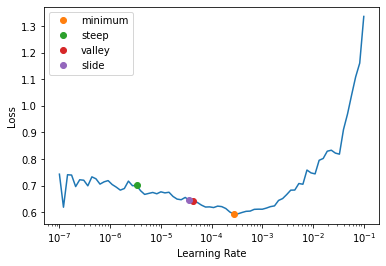

In [17]:
lr_res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [19]:
learn.fit_one_cycle(3, 
                    lr_max=5e-5, 
                   # cbs=[WandbCallback(log_preds=False, log_model=False)]
                    ) 

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.489475,0.360611,0.855392,0.898799,00:57
1,0.271378,0.331806,0.852941,0.893993,00:58
2,0.065731,0.414503,0.867647,0.904594,00:59


In [20]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,""" biotech products, if anything, may be safer than conventional products because of all the testing, "" fraley said, adding that 18 countries have adopted biotechnology. "" biotech products, if anything, may be safer than conventional products because of all the testing, "" said robert fraley, monsanto's executive vice president.",0,0
2,"kansas department of health and environment records show there were 88 abortions performed on girls age 14 and younger last year. statistics from the kansas department of health and environment show that 11, 844 abortions were performed in the state last year.",0,1
3,carlson on tuesday said he would not recuse himself from the case. service officials said carlson refused to recuse himself from the case.,1,1
4,the mother of a briton held by colombian guerrillasspoke of her relief yesterday after hearing that he might be freed in the next few weeks. the parents of a briton being held hostage by colombian rebels spoke yesterday of their optimism that he would be freed in time for his birthday next month.,0,1


### Evaluierung der Ergebnisse

In [21]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'accuracy': 0.8676470518112183,
 'f1_score': 0.9045936395759717,
 'loss': 0.4145026206970215}

In [22]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([408, 2]) torch.Size([408]) torch.Size([408])
TensorBase(0.4145) TensorBase(0.8676)


In [23]:
# wandb.finish()

### Inference mit unserem Modell

In [24]:
learn.export('mrpc_learner.pkl')

In [25]:
inf_learn = load_learner('mrpc_learner.pkl')

In [26]:
# Einzelne Items als Input für unser Modell:
inf_learn.blurr_predict({'sentence1': 'this is looking really great', 
                         'sentence2': 'Dogs are better than cats!!!'})

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9880, 0.0120])])]

In [27]:
inf_learn.blurr_predict([
                         {'sentence1': 'this is looking really great', 
                          'sentence2': 'Dogs are better than cats!!!'},
                         {'sentence1': 'Dogs are the best', 
                          'sentence2': 'Dogs are better than cats!!!'}
                        ])

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9880, 0.0120])]),
 (('1',), (#1) [tensor(1)], (#1) [tensor([0.0134, 0.9866])])]

In [29]:
# Inference für einen gesamten Batch:
test_dl = inf_learn.dls.test_dl(raw_datasets['test'].select(range(100)))
preds = inf_learn.get_preds(dl=test_dl)
preds[0][:10]

tensor([[0.0027, 0.9973],
        [0.2606, 0.7394],
        [0.0016, 0.9984],
        [0.0953, 0.9047],
        [0.9916, 0.0084],
        [0.0014, 0.9986],
        [0.7319, 0.2681],
        [0.4180, 0.5820],
        [0.0082, 0.9918],
        [0.9889, 0.0111]])

## Einsatz der High-Level API
Learner "out-of-the-box" für Standardanwendungen

In [30]:
from blurr.modeling.core import BlearnerForSequenceClassification

In [31]:
raw_datasets = load_dataset('glue', 'mrpc') 

train_df = raw_datasets['train'].to_pandas()
train_df['is_valid'] = False

valid_df = raw_datasets['validation'].to_pandas()
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [32]:
# wandb.init(**wandb_init_kwargs)

In [33]:
learn = BlearnerForSequenceClassification.from_dataframe(df, 
                                                         checkpoint, 
                                                         text_attr=['sentence1', 'sentence2'], 
                                                         label_attr='label', 
                                                         dl_kwargs={'bs': bsz, 'val_bs': val_bsz})

In [35]:
learn.unfreeze()
learn.fit_one_cycle(3, 
                    lr_max=5e-5, 
                    #cbs=[WandbCallback(log_preds=False, log_model=False)]
                    )

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.459910,0.409743,0.879159,0.830882,00:59
1,0.268167,0.354023,0.890877,0.850490,01:00
2,0.084858,0.389319,0.900685,0.857843,01:00


In [36]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,large swells and dangerous surf already were being felt along sections of the coast. already large swells and dangerous surf have arrived along the mid - atlantic.,1,1
2,q : can i buy coverage for prescription drugs right away? congress has added a new benefit - an option to buy insurance coverage for prescription drugs.,0,0
3,"lu reclined in a soft chair wearing a woolly coat near the blackened capsule. "" it's great to be back home, "" said lu, dressed in a woolly coat near the blackened capsule.",0,0
4,"wal - mart has said it plans to open at least 40 supercenters in the state in the coming years ; analysts expect four or more to be in san diego county. at least 40 of the outlets will be in california, and analysts expect four or more to be in san diego county.",0,1


In [37]:
# Inference
learn.export('mrpc_learner2.pkl')
inf_learn2 = load_learner('mrpc_learner2.pkl')

In [38]:
print(df[['sentence1', 'sentence2']].iloc[0])
inf_learn2.blurr_predict(df.iloc[0])

sentence1            Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
sentence2    Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Name: 0, dtype: object


[(('1',), (#1) [tensor(1)], (#1) [tensor([0.0055, 0.9945])])]

In [39]:
inf_learn2.blurr_predict([L('I love cats', 'I kind of like cats')])

[(('1',), (#1) [tensor(1)], (#1) [tensor([0.1233, 0.8767])])]

In [40]:
test_df = (raw_datasets['test'].select(range(100))).to_pandas()

test_dl = inf_learn2.dls.test_dl(test_df)
preds = inf_learn2.get_preds(dl=test_dl)
preds[0][:10]

tensor([[0.0045, 0.9955],
        [0.1613, 0.8387],
        [0.0043, 0.9957],
        [0.1347, 0.8653],
        [0.9104, 0.0896],
        [0.0029, 0.9971],
        [0.5205, 0.4795],
        [0.0473, 0.9527],
        [0.0207, 0.9793],
        [0.9913, 0.0087]])

In [41]:
# wandb.finish()